In [76]:
import pandas as pd
import numpy as np
import requests
import scipy.stats as stats

In [2]:
pip install requirements.txt

Note: you may need to restart the kernel to use updated packages.


  ERROR: Could not find a version that satisfies the requirement requirements.txt (from versions: none)
ERROR: No matching distribution found for requirements.txt


In [60]:
def get_data(token):
    if token != 'FLOW':
        res = requests.get(
            f'https://api.cryptowat.ch/markets/coinbase-pro/{token}usd/ohlc',
            params={
                'periods': '3600',
                'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
            }
        )
    else:
        res = requests.get(
            f'https://api.cryptowat.ch/markets/kraken/{token}usd/ohlc',
            params={
                'periods': '3600',
                'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
            }
        )
    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df

In [5]:
tokens = ['ETH', 'SOL', 'AVAX', 'USDT', 'FLOW']

In [14]:
df_USD_volume = pd.DataFrame()
for token in tokens:
    df_USD_volume[token] = get_data(token)['volumeUSD'].apply(lambda x:float(x))
df_USD_volume.loc["Total_USD_volume"] = df_USD_volume.sum()

In [15]:
df_results = pd.DataFrame(df_USD_volume.loc["Total_USD_volume"].T).sort_values('Total_USD_volume', ascending = False)

In [16]:
df_close_ratio = pd.DataFrame(get_data('ETH')['close']/get_data('SOL')['close'])

In [45]:
df_close_price = pd.DataFrame()
for token in tokens:
    df_close_price[token] = get_data(token)['close'].apply(lambda x:float(x))
df_close_price.index = get_data('ETH')['ts']

In [63]:
df_close_price.rename(
    columns={
        'volume':'volumeBase',
        'volumeUSD':'volumeTerm'
    }
)

,ETH,SOL,AVAX,USDT,FLOW
ts,,,,,
2021-11-22 00:00:00,4262.99,230.785,128.67,1.0012,14.150
2021-11-22 01:00:00,4234.37,226.000,134.85,1.0013,13.621
2021-11-22 02:00:00,4217.89,227.037,132.54,1.0012,13.753
2021-11-22 03:00:00,4193.47,223.117,133.38,1.0011,13.652
2021-11-22 04:00:00,4168.35,220.652,136.29,1.0009,13.581
...,...,...,...,...,...
2021-12-29 10:00:00,3814.72,177.460,107.50,1.0000,8.683
2021-12-29 11:00:00,3793.32,176.980,107.10,0.9999,8.648
2021-12-29 12:00:00,3790.82,175.600,107.14,1.0001,8.622


In [55]:
import copy
def compute_log_returns(df_close_prices):
    df_close_log_returns = copy.deepcopy(df_close_prices)
    for token in tokens:
        df_close_log_returns[token+'_t-1'] = df_close_log_returns[token].apply(lambda x:float(x)).shift(1)
        df_close_log_returns[token+'_log_return'] = np.log(df_close_log_returns[token]/df_close_log_returns[token+'_t-1'])
        del df_close_log_returns[token+'_t-1']
        del df_close_log_returns[token]
    return(df_close_log_returns)
    # faire une colonne en décalé avec .diff puis la virer après coup

In [57]:
df_close_log_return = compute_log_returns(df_close_price)

In [67]:
import matplotlib.pyplot as plt

ETH vs SOL Pearson Correlation: 0.7549575065906635



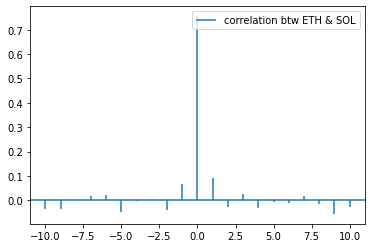

ETH vs AVAX Pearson Correlation: 0.6573094837261546



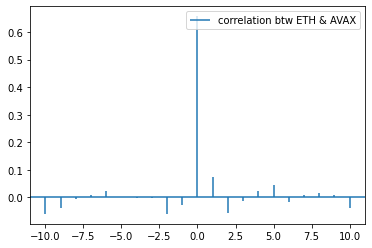

ETH vs USDT Pearson Correlation: -0.07318307856189002



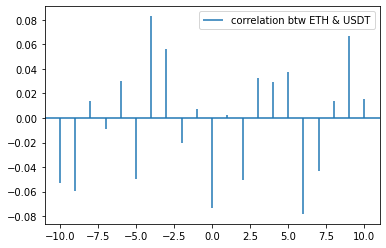

ETH vs FLOW Pearson Correlation: 0.5639244133167389



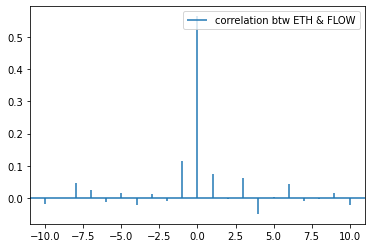

SOL vs ETH Pearson Correlation: 0.7549575065906635



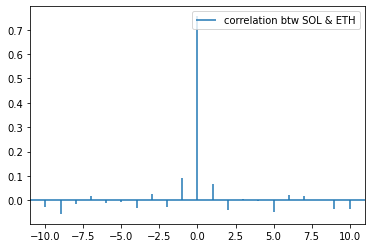

SOL vs AVAX Pearson Correlation: 0.6499069738242599



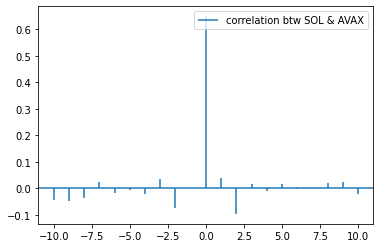

SOL vs USDT Pearson Correlation: 0.10550562570431404



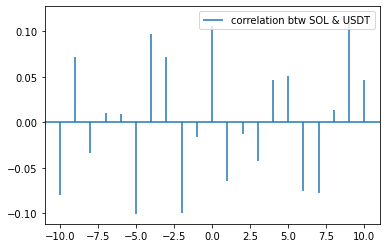

SOL vs FLOW Pearson Correlation: 0.4647208823390742



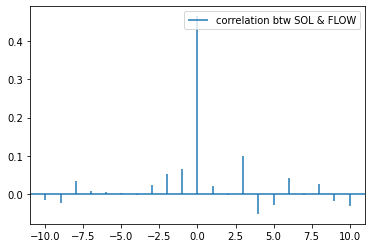

AVAX vs ETH Pearson Correlation: 0.6573094837261546



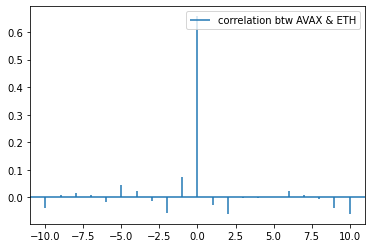

AVAX vs SOL Pearson Correlation: 0.6499069738242599



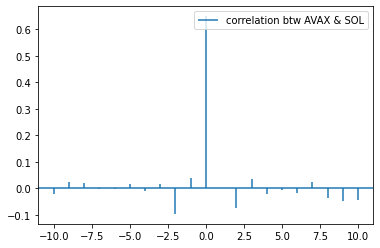

AVAX vs USDT Pearson Correlation: 0.024700719196567432



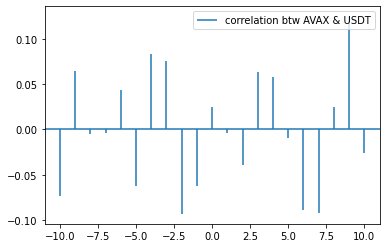

AVAX vs FLOW Pearson Correlation: 0.41470499693061186



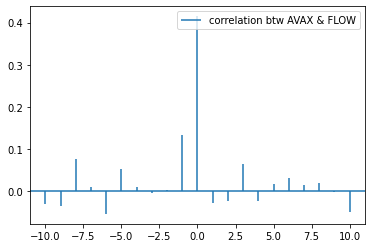

USDT vs ETH Pearson Correlation: -0.07318307856189002



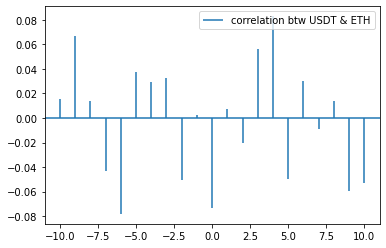

USDT vs SOL Pearson Correlation: 0.10550562570431404



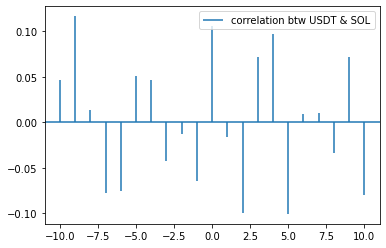

USDT vs AVAX Pearson Correlation: 0.024700719196567432



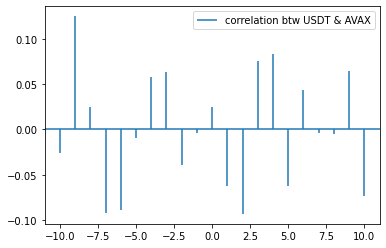

USDT vs FLOW Pearson Correlation: -0.16104732501923597



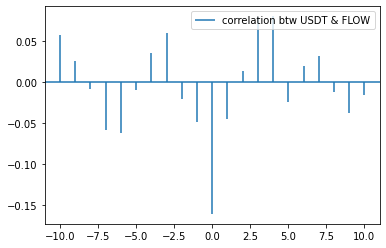

FLOW vs ETH Pearson Correlation: 0.5639244133167389



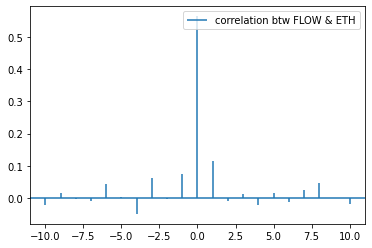

FLOW vs SOL Pearson Correlation: 0.4647208823390742



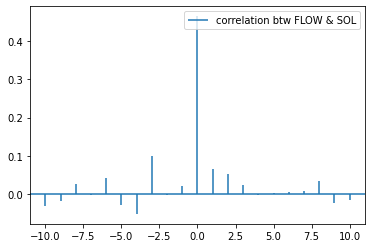

FLOW vs AVAX Pearson Correlation: 0.41470499693061186



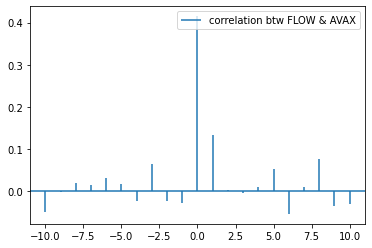

FLOW vs USDT Pearson Correlation: -0.16104732501923597



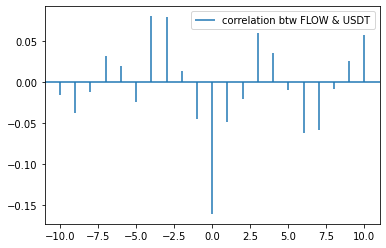

In [80]:
for token_x in tokens:
    for token_y in tokens:
        if token_x != token_y:
            x_data = df_close_log_return[token_x+'_log_return'][1:]
            y_data = df_close_log_return[token_y+'_log_return'][1:]
            plt.xcorr(x_data, y_data, label = 'correlation btw '+token_x+' & '+token_y)
            c, p = stats.pearsonr(x_data, y_data)
            print("{} vs {} Pearson Correlation: {}\n".format(token_x, token_y,c))
            plt.legend()
            plt.show()